# Movie Review Sentiment CLassifer

Daniel Cersosimo



# Initial Exploration





In [ ]:


#Here I import the necessary libraries; the reasonings for each will be discussed at their usage points
import pandas as pd
import numpy as np
import sklearn as sk
import string as st
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()






[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Thi loads the data; path is for google colab as this is the enviroment I worked in
path = "/content/IMDB Dataset.csv"
df = pd.read_csv(path)

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Data Preproccessing

**1.) Check Missing Nulls Values**

In [ ]:
#See nulls
df.isnull().value_counts()

review  sentiment
False   False        50000
dtype: int64

In [ ]:
#Summary statistics, interesting to see duplicates
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
#Hanlde the duplicates by removing them from the df
df.drop_duplicates(inplace=True)

In [ ]:
#Show the statistics again as a means of confirming the duplicate removal
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


**2.) Remove Noise and Special Characters, 3.) transform all words to lowercase, 4.) Word tokenization, and 5.) Stop words removing and stemming**

In [ ]:
#Define the raw review text as an object
raw_reviews = df['review']
sc = ['\t', '\n', '\r', ' ', '&', '*', '{', '}', '[', ']', '=', '-', '()', '+', '/']

#This is a two layered nested loop which effectivley iterates throught the reviews, terms of said review, and characters of said term
#in order to process the via the methods in the above markdown block.
cleaned_reviews = {}
for i, ID in zip(raw_reviews, range(len(raw_reviews))):
    #Here I utilize beautifulsoup to essentially extract the review text without the html tags
    parse_tree = BeautifulSoup(i, 'html.parser')
    remove_html = parse_tree.get_text(separator=" ")
    #With the text free of html tages, I proceed to break the review into terms split on whitespace
    clean_terms = []
    terms = remove_html.split(" ")
    for t in terms:
        #For every term, I ensure it is of a valid character and proceed to iterate through said characters
        clean_term = []
        if t == " ":
            continue
        for char in t:
            #As I work through the characters, I esnure the character is not a special character or punctuation and if not append it to a list
            if char not in st.punctuation:
                clean_term.append(char)
        #This cleaned character list is then joined into cleaned terms which are then lowercased
        cleaned_term = "".join(clean_term)
        cleaned_term = cleaned_term.lower()
        #If the cleaned term is a stop word, the loop proceeds to the next term, effectivley removing stop words
        if cleaned_term in stop_words:
            continue
        #Here I utilize a lemmatizer instead of stemming since this practice if term conversion simplfies them into terms whihc
        #are more likely to be lingusitically aligned and not stems which are not actual terms. This is important since I will
        #be utilizing word embedding which may have difficulty working with stems which are not real terms and therefore may not be in the corpus of the training
        cleaned_term = lemmatizer.lemmatize(cleaned_term)
        #These finalized terms are consolidated to a list for the review
        clean_terms.append(cleaned_term)
    #This list is then joined back into a string since this is the input necessary for the word embedding and added to the dictionary
    clean_terms = " ".join(clean_terms)
    cleaned_reviews[f'Review {ID + 1}'] = clean_terms

<ipython-input-10-8311d8490920>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  parse_tree = BeautifulSoup(i, 'html.parser')


In [ ]:
#Show the cleaned review text
cleaned_reviews

{'Review 1': 'reviewer mentioned watching just 1 oz episode youll hooked right exactly happened thing struck oz brutality unflinching scene violence set right word trust faint hearted timid pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement far away say main appeal fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess episode saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence just violence injustice crooked guard wholl sold nickel inmate wholl kill order away mannered middle class inmate turned prison bitch lack street skill prison experience watching oz comfortable 

In [ ]:
#This downloads the pre trained word2vec model which I will employ to generate vectors for each term in each term in each review.
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

In [ ]:
#This code block is a nested loop which houses the logic for the vector generation from the review text
review_vectors = {}
for ID, rev in cleaned_reviews.items():
  #This breaks the cleaned text string into a list of terms
  terms = rev.split(" ")
  term_vectors = []
  for term in terms:
    #Here I iterate through each term and compute the vector represented in 300 dimenional space for each term and add to a list
    if term in word2vec_model:
      term_vectors.append(word2vec_model[term])
  #The vectors for each term are then aggregated to give every review an averaged 300 dimensional vector, represntative of the terms within.
  #This is needed for two reasons, one is to avoid the differnt lenght reviews resulting in variation in input length, not suitable for ML models
  #Two is to streamline the computation which will be needed by said models given the limits on the resources
  review_vector = sum(term_vectors) / len(term_vectors)
  review_vectors[ID] = review_vector

In [ ]:
#This displays the aggregated 300 dimensional vectors for each review as a product fo the above code
review_vectors

In [ ]:
#This creates a df for the reviews and their vector reprsentation
review_data = pd.DataFrame(list(review_vectors.values()), index=review_vectors.keys())

In [ ]:
#Here I convert the target variavle into bianry 1 for positive and 0 for negative
binary_sentiments = []
for i in df['sentiment']:
  if i == 'positive':
    binary_sentiments.append(1)
  if i == 'negative':
    binary_sentiments.append(0)

In [ ]:
#This adds the binary sentiment feature to the review vector df
review_data['Sentiment'] = binary_sentiments

In [ ]:
#Shows the finalized df ready for modeling
review_data

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Sentiment
Review 1,0.051480,0.027759,0.061519,0.099049,-0.065699,0.016541,0.052244,-0.100357,0.067061,0.086787,...,-0.006995,-0.099679,0.008187,-0.056747,-0.019394,0.013682,-0.077216,0.026507,0.001323,1
Review 2,0.088052,0.051718,-0.017062,0.056006,-0.027639,0.050178,0.046791,-0.090350,0.100325,0.083063,...,0.032794,-0.046296,0.005180,-0.058106,-0.044682,0.058092,-0.075025,0.010597,-0.005823,1
Review 3,0.061447,0.048288,0.010137,0.103878,-0.042130,0.005616,0.068326,-0.051979,0.076319,0.098286,...,0.065624,-0.110746,-0.020079,-0.078369,-0.043201,0.041076,-0.086644,-0.004536,0.018684,1
Review 4,0.085311,0.007862,0.002686,0.113674,-0.057425,0.045128,0.052849,-0.042714,0.106634,0.086296,...,0.056915,-0.160332,0.031736,-0.048182,-0.034946,-0.012332,-0.048576,-0.000971,0.062830,0
Review 5,0.025926,0.032086,-0.003513,0.069964,-0.037163,0.014743,0.051540,-0.064500,0.069907,0.052747,...,0.064140,-0.092322,-0.005174,-0.049838,-0.015159,0.003096,-0.070846,0.010340,-0.005816,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Review 49578,0.053941,0.000949,0.001289,0.158877,-0.034785,0.036879,0.080476,-0.050950,0.063795,0.083061,...,0.086444,-0.102794,0.035832,-0.034771,-0.066391,-0.017366,-0.076126,0.014108,-0.015711,1
Review 49579,0.064081,0.026201,0.045074,0.106650,-0.099628,0.038181,0.037536,0.007985,0.074880,0.082880,...,0.117627,-0.084005,0.021388,-0.029470,0.023452,-0.012097,-0.063081,0.010365,0.045168,0
Review 49580,0.100350,0.018082,0.077960,0.120887,-0.043638,0.014525,0.068472,-0.055543,0.089037,0.051707,...,0.017247,-0.167274,-0.006042,-0.077664,0.031312,0.031132,-0.052352,0.026887,0.057797,0
Review 49581,0.083521,0.059228,0.007952,0.063526,-0.037327,-0.014329,0.059073,-0.068759,0.093655,0.110628,...,0.031026,-0.065192,0.023888,-0.063358,-0.046527,0.015697,-0.083627,0.010268,0.042666,0


**6.) Divide the dataset into train and test split via random sampling**

In [ ]:
#Import sckikit learns train test split to streamline the process of generating these sets via random sampling
from sklearn.model_selection import train_test_split

X = review_data.iloc[:, :-1]
y = review_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [ ]:
y

Review 1        1
Review 2        1
Review 3        1
Review 4        0
Review 5        1
               ..
Review 49578    1
Review 49579    0
Review 49580    0
Review 49581    0
Review 49582    0
Name: Sentiment, Length: 49582, dtype: int64

# Modeling



  Logistic Regression

  LinearSVC

  KNeighborsClassifier

  Fully-connected layers

  CNN


In [ ]:

from sklearn.metrics import classification_report

**1.) Logistic Regression**

In [ ]:
#
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#This loads and trains a logistic regression model on the training set from the above split and then predicts according the the input test
logistic_reg_model = LogisticRegression(max_iter=1000)
logistic_reg_model.fit(X_train, y_train)
y_pred_log = logistic_reg_model.predict(X_test)
#Gauge metrics for evauluation by comparing predictions against the actuals
accuracy = accuracy_score(y_test, y_pred_log)
print("Accuracy:", accuracy)


Accuracy: 0.85378642734698


In [ ]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4946
           1       0.85      0.86      0.85      4971

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



**2.) LinearSVC**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

#This loads and trains a Support Vector Linear Classifer on the training set from the above split and then predicts according the the input test
svc_model = LinearSVC(max_iter=10000)
svc_model.fit(X_train, y_train)
y_pred_SVC = svc_model.predict(X_test)
#Gauge metrics for evauluation by comparing predictions against the actuals
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)


Accuracy: 0.8574165574266411


In [ ]:
print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4946
           1       0.86      0.86      0.86      4971

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



**3.) KNeighborsClassifer**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#This loads and trains a k-NN classifer on the training set from the above split and then predicts according the the input test
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
#Gauge metrics for evauluation by comparing predictions against the actuals
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)


Accuracy: 0.7935867701925986


In [ ]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      4946
           1       0.81      0.77      0.79      4971

    accuracy                           0.79      9917
   macro avg       0.79      0.79      0.79      9917
weighted avg       0.79      0.79      0.79      9917



**4.) Fully-connected layers neural network via FNN**

In [ ]:
#For this I sought to design the arcitecture for a neural network which abides by the criteria of the 4th model above
#In order to execute this, I employed a feedforward neural network comprised of dense layers and a dropout layer.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#I start by defining my model using keras sequential model as it is a vertatile model which I can harness to construct
#my feedforward neural network. I use relu in the non output layers below as a measn to allow for nonlinear patters to be caputred
##Here I add the first input layer with the shape of 300 for the vectir dimensions, intilaize it with relu adn 128 neurons, and add in
#another dense hidden layer for enhanced complexity for the model to pick up on intricaices in the data along
#with a dropout layer to combat overfitting by dropping 50 percent of neurons at each iteration via random slection
model = Sequential([
    Dense(128, activation='relu', input_shape=(300,)),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Adding dropout regularization
    Dense(1, activation='sigmoid')  # Binary classification output
])
#I add an output layer of one neruon for the single binary classicftion output. I utilize sigmoid activiatuon here
#as this provides the means of the either 0 or 1 outputted value

#This compiles the arictecyture I deisgend above by initlaizing it wiht the adam optimzer, the bianry loss for classification and accuray for eval
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Here I print the architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               38528     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 46849 (183.00 KB)
Trainable params: 46849 (183.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:


#Here I apply my configured FNN above to be trained on the data via the specifications below
#I ran a few epoch and batch size variations and found 12 and 35 to be a good balance between performance and efficiency
Train_FNN = model.fit(X_train, y_train, epochs=12, batch_size=35, validation_split=0.2)
#Here I evaluate via accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/12
907/907 [==============================] - 7s 7ms/step - loss: 0.3679 - accuracy: 0.8436 - val_loss: 0.3541 - val_accuracy: 0.8489
Epoch 2/12
907/907 [==============================] - 4s 5ms/step - loss: 0.3579 - accuracy: 0.8497 - val_loss: 0.3465 - val_accuracy: 0.8504
Epoch 3/12
907/907 [==============================] - 3s 3ms/step - loss: 0.3517 - accuracy: 0.8519 - val_loss: 0.3729 - val_accuracy: 0.8340
Epoch 4/12
907/907 [==============================] - 3s 4ms/step - loss: 0.3454 - accuracy: 0.8531 - val_loss: 0.3868 - val_accuracy: 0.8316
Epoch 5/12
907/907 [==============================] - 3s 3ms/step - loss: 0.3395 - accuracy: 0.8544 - val_loss: 0.3593 - val_accuracy: 0.8432
Epoch 6/12
907/907 [==============================] - 5s 5ms/step - loss: 0.3345 - accuracy: 0.8582 - val_loss: 0.3341 - val_accuracy: 0.8573
Epoch 7/12
907/907 [==============================] - 4s 4ms/step - loss: 0.3295 - accuracy: 0.8601 - val_loss: 0.3342 - val_accuracy: 0.8581
Epoch 

In [ ]:
#This gets predictions for the FNN
y_pred_FNN = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred_FNN))

310/310 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      4946
           1       0.88      0.83      0.86      4971

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



**5.) CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

#Again I leverage keras sequntial to construct my CNN. In addiiton, I also deisgn this by fully connecting the layers

#I utilize two convulutional layers 200 and 100 filters each after experimentation with a max pooling for each to primnarliy
#improve computation as this is quite intensive. The input shape is 300 for the dimensions of the vectors.
#I utilize a flatten layer to effecivley connect the convolutional layer output to be fed into the Dense layer
#which is involved with relu activation to capture nonlinearlity with a dropout for the same reasons before
model_cnn = Sequential([
    Conv1D(filters=200, kernel_size=3, activation='relu', input_shape=(300, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=100, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
#The single neuron output dense layer uses sigmoid for the 0 or 1 binary output

#The deisgned arictecutre above is compiled to be ready for usage via the same configurations as the FNN
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

#Here I show the structure
model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 298, 200)          800       
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 200)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 100)          60100     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 73, 100)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 7300)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:


#This runs the data through the CNN where I utilize 12 epochs and 35 batch size. Limited experimentation due to the time it take to run this
#However I did with some smaller values for both
Train_CNN = model_cnn.fit(X_train, y_train, epochs=12, batch_size=35, validation_split=0.2)

#Here I evaluate the model via accuracy
loss, accuracy = model_cnn.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/12
907/907 [==============================] - 100s 109ms/step - loss: 0.4703 - accuracy: 0.7783 - val_loss: 0.3855 - val_accuracy: 0.8259
Epoch 2/12
907/907 [==============================] - 102s 113ms/step - loss: 0.3958 - accuracy: 0.8288 - val_loss: 0.3631 - val_accuracy: 0.8415
Epoch 3/12
907/907 [==============================] - 97s 107ms/step - loss: 0.3837 - accuracy: 0.8345 - val_loss: 0.3660 - val_accuracy: 0.8351
Epoch 4/12
907/907 [==============================] - 94s 104ms/step - loss: 0.3712 - accuracy: 0.8399 - val_loss: 0.3522 - val_accuracy: 0.8427
Epoch 5/12
907/907 [==============================] - 91s 101ms/step - loss: 0.3683 - accuracy: 0.8421 - val_loss: 0.3526 - val_accuracy: 0.8456
Epoch 6/12
907/907 [==============================] - 93s 103ms/step - loss: 0.3639 - accuracy: 0.8463 - val_loss: 0.3478 - val_accuracy: 0.8489
Epoch 7/12
907/907 [==============================] - 96s 106ms/step - loss: 0.3569 - accuracy: 0.8472 - val_loss: 0.3433 - val_

In [ ]:
##This gets predictions for the CNN
y_pred_CNN = (model_cnn.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred_CNN))

310/310 [==============================] - 13s 40ms/step
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4946
           1       0.84      0.88      0.86      4971

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



# Results and Evaluation


In [ ]:



from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



**Logistic Regression Confusion Matrix**

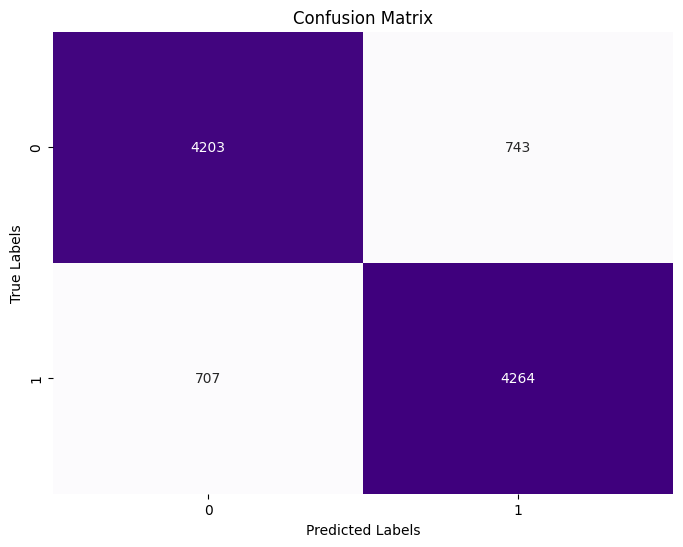

In [ ]:
cm = confusion_matrix(y_test, y_pred_log)

#This plots the log confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

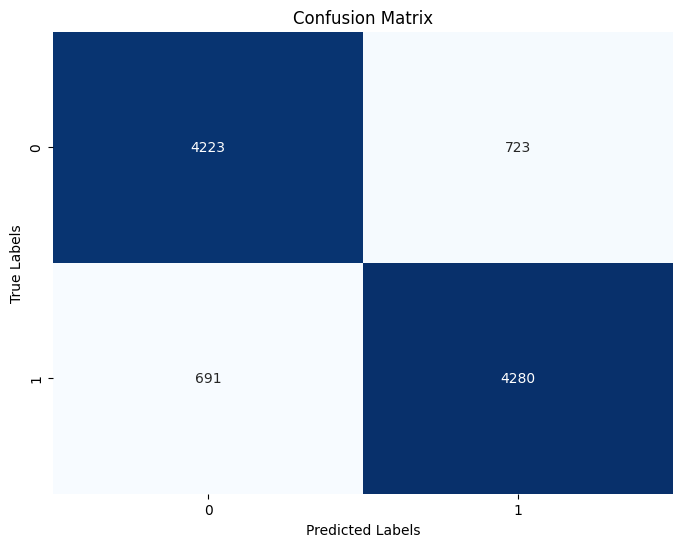

In [ ]:
cm = confusion_matrix(y_test, y_pred_SVC)

#This plots the SVC confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

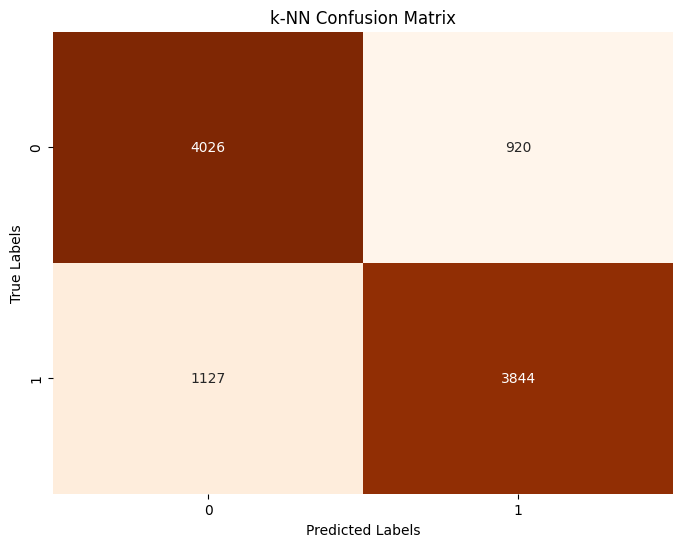

In [ ]:
cm = confusion_matrix(y_test, y_pred_knn)

#This plots the k-NN confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('k-NN Confusion Matrix')
plt.show()

310/310 [==============================] - 2s 6ms/step


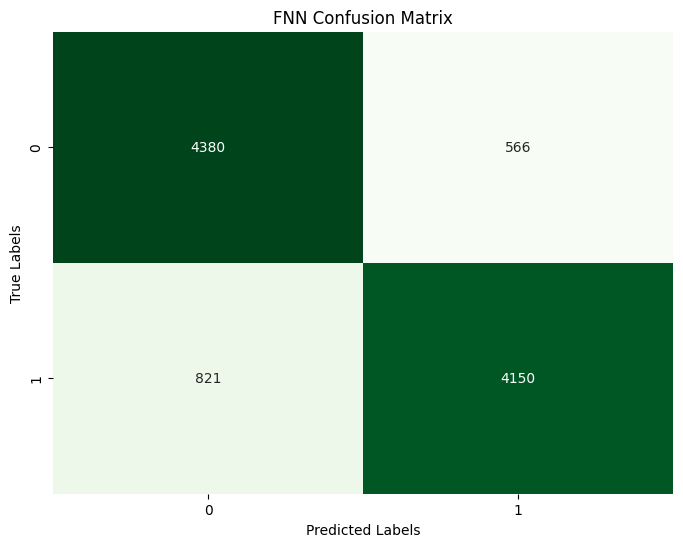

In [ ]:


#This gets predictions for the FNN
y_pred_FNN = (model.predict(X_test) > 0.5).astype(int)

#This generates the confusion matrix and plots it for FNN
cm = confusion_matrix(y_test, y_pred_FNN)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('FNN Confusion Matrix')
plt.show()


310/310 [==============================] - 10s 31ms/step


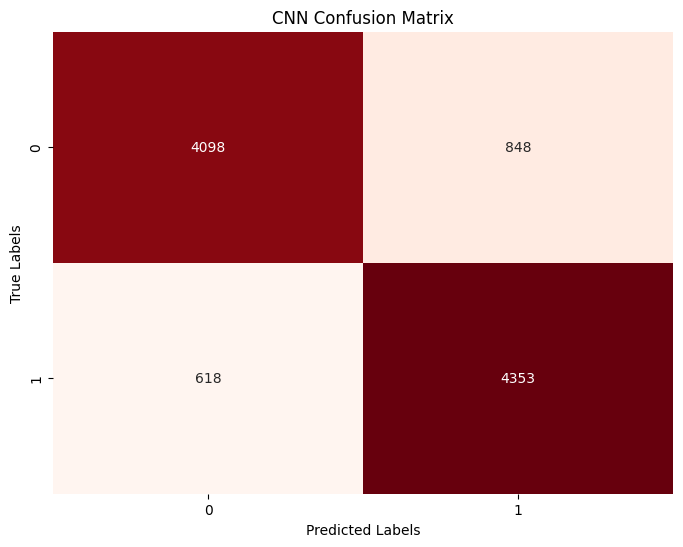

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

##This gets predictions for the CNN
y_pred_CNN = (model_cnn.predict(X_test) > 0.5).astype(int)

##This generates the confusion matrix and plots it for CNN
cm = confusion_matrix(y_test, y_pred_CNN)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.show()
